In [4]:
import numpy as np
import scipy as sp
import pandas as pd
from os import listdir
import shutil
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
from sklearn.manifold import TSNE
import subprocess
import shlex
from sklearn.metrics import r2_score
import random

# todo:
# https://www.embopress.org/doi/full/10.15252/msb.20188746
# https://scanpy.readthedocs.io/en/stable/tutorials.html
# umap / tsne on the whole dataset to see if ages are naturally seperable


Aging is the time dependant weaking of the body. For example, aging in the pancreous can predispose people to diabetes (https://www.imrpress.com/journal/FBE/10/1/10.2741/e813). I will attempt to find theraputic targets that could be used to target aging in the pancreatus using scRNA-Seq data from  https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE81547.

A good target is a gene or pathway that:

(1) Has reletively constant expression accross cells from the same individual. Targeted cell delivery is a hard process, especially between cell types in the same organ, so the genes or pathways need to be consistant accross the single cells.

(2) Is highly corralative with age. This is less important because if there is a gene whose expression is dependant on age in some nonlinear maner, it could still be a good target if it is modulated carefully. This is a simplifying assumption.

(3) Has a large magnatude of change with age. Something that only changes subtley with age will be harder to modulate. This is more for gene selection rather than pathway selection.

# Data Preprocessing

Creates the aggragated data for each sample in the ClupedData folder

This just puts the data in a nicer form for downstream processing: files named with the donor age and sex with the counts of each RNA in each row.

This is the description of the data:

	As organisms age, cells accumulate genetic and epigenetic changes that eventually lead to impaired organ function or catastrophic failure such as cancer. Here we describe a single-cell transcriptome analysis of 2544 human pancreas cells from donors, spanning six decades of life. We find that islet cells from older donors have increased levels of disorder as measured both by noise in the transcriptome and by the number of cells which display inappropriate hormone expression, revealing a transcriptional instability associated with aging. By analyzing the spectrum of somatic mutations in single cells from previously-healthy donors, we find a specific age-dependent mutational signature characterized by C to A and C to G transversions, indicators of oxidative stress, which is absent in single cells from human brain tissue or in a tumor cell line. Cells carrying a high load of such mutations also express higher levels of stress and senescence markers, including FOS, JUN, and the cytoplasmic superoxide dismutase SOD1, markers previously linked to pancreatic diseases with substantial age-dependent risk, such as type 2 diabetes mellitus and adenocarcinoma. Thus, our single-cell approach unveils gene expression changes and somatic mutations acquired in aging human tissue, and identifies molecular pathways induced by these genetic changes that could influence human disease. Also, our results demonstrate the feasibility of using single-cell RNA-seq data from primary cells to derive meaningful insights into the genetic processes that operate on aging human tissue and to determine which molecular mechanisms are coordinated with these processes.

This dataset contains scRNA-seq data on the pancreas of humans of various ages.

In [5]:
path = 'GSE81547'
datasets = sorted([path+'/'+i for i in listdir(path)])

pd.read_csv(datasets[0],delimiter='\t',header=None)

,0,1
0,1/2-SBSRNA4,0
1,A1BG,0
2,A1BG-AS1,0
3,A1CF,0
4,A2LD1,0
...,...,...
23460,no_feature,407558
23461,ambiguous,3754
23462,too_low_aQual,0
23463,not_aligned,0


The files themselves don't contain any information on the samples. Clumn 0 contains the gene and column 1 contains the Transcript counts. The last 5 rows contains data on the RNA-Seq preprocessing. First lets use the metadata file to get the ages and sexes of each sample.

In [6]:
id2file = lambda id: [i for i in datasets if i[i.find('/')+1:i.find('_')] == id][0]
with open('GSE81547_series_matrix.txt') as f:
    for line in f:
        if line.startswith('!Series_sample_id'):
            identifier = line[len('!Series_sample_id\t')+1:-3].split(' ')
        if line.startswith('!Sample_title'):
            donor = [(int(i[1:i.find('yr')]),i[i.find('_')+1]) for i in line[len('!Sample_title\t'):].split('\t')]
            donor = [(i, [id2file(identifier[j]) for j,k in enumerate(donor) if k == i]) for i in set(donor)]
donor.sort()

In [7]:
for id,files in donor:
    dfs = [pd.read_csv(files[0],delimiter='\t',header=None)] + [pd.read_csv(f,delimiter='\t',header=None)[1] for f in files[1:]]
    totdata = pd.concat(dfs,axis=1).iloc[:-5, :]
    totdata.columns = ['Gene'] + list(range(len(totdata.columns)-1))
    totdata.to_csv(f'ClumpedData/{"0"*(id[0]<10)}{id[0]}_{id[1]}.csv',index=False,sep='\t')

Now we have a function that takes the file name and returns the metadata

# Data Cleaning

I will be using enhance from https://www.biorxiv.org/content/10.1101/655365v2.full

The algorithm is incredibly simple. It basically assumes the data has a large nullspace and the data is noisy and uses PCA to choose which dimensions to keep.

In [8]:
folder = 'ClumpedData/'
for file in listdir(folder):
    subprocess.call(shlex.split(f'python3 enhance/enhance.py -f {folder+file} -o DenoisedData/{file} --seed 0'))


Now that the data is denoised, I can start removing genes that won't help me find a theraputic target for aging.

The first thing to do would be removing genes whose standard deviation is larger within groups that throughout groups. The only reason this is valid is because I already cleaned the data to (hopefully) remove the technical noise. I will also log transform the data, as is standard with scRNA seq.

In [9]:
folder = 'DenoisedData/'
stds = []
means = []
for i,f in enumerate(sorted(listdir(folder))):
    df = pd.read_csv(folder+f,delimiter='\t')
    counts = df[df.columns[1:]]
    genes = df['Gene']
    print('(Genes, Cells) =',counts.shape)
    genemean = counts.mean(axis=1)
    genestd = counts.std(axis=1)

    
    stds += [genestd]
    means += [genemean]

stds = np.array(list(stds))
means = np.array(list(means))
outgroupstd = means.std(axis=0)
ingroupstd = np.median(stds,axis=0)
print('Failed genes due to high in group variance:',sum(ingroupstd >= outgroupstd))
print('Possible genes:',sum(ingroupstd < outgroupstd))
potentialgenes = genes[ingroupstd < outgroupstd]


(Genes, Cells) = (23460, 221)
(Genes, Cells) = (23460, 331)
(Genes, Cells) = (23460, 178)
(Genes, Cells) = (23460, 505)
(Genes, Cells) = (23460, 286)
(Genes, Cells) = (23460, 474)
(Genes, Cells) = (23460, 277)
(Genes, Cells) = (23460, 272)
Failed genes due to high in group variance: 16102
Possible genes: 7358


# Genes Monotonically Corrolated with Age

Let's search for any genes that highly corrolate with age. They would be potential targets

I use the Spearmans r and p values to find genes that are associated with aging. I am using Spearmanr because I only care that the relashionship is monotonic, not that it is linear.

In [11]:
# print(means.shape)
t = [int(i[:2]) for i in sorted(listdir(folder))]
goodinds = []
for i,y in enumerate(means[:,potentialgenes.index].T):
    if np.max(y) > 1:
        r,p = sp.stats.spearmanr(t,y)
        if abs(r) > 0.8 and p < 0.05:
            goodinds += [potentialgenes.index[i]]


print('Corrolated genes that also work with the spearmons corrolation criteria:',len(goodinds))
with open('TargetGenesV1.txt','w+') as f:
    for i in genes[goodinds]:
        print(i,end='\t')
        f.write(i+'\n')

Corrolated genes that also work with the spearmons corrolation criteria: 37
AGT	ANKRD26P1	ARVCF	BAI2	CCDC65	CDCA7	CHRDL2	CRH	DGKQ	DLGAP3	DLL3	FIZ1	GAB3	HIST1H1D	JRK	KIAA1644	LCN10	LEF1	LOC100506134	LOC389332	MYBPHL	ORM1	PCK2	PID1	PRKG1	RBM24	SAA1	SHISA7	SIX3	SMOC1	SUGT1P3	TAF10	TFF1	TMEM176B	TOR2A	TSIX	VGF	

# Reactome Pathway Analysis

Aging has many causes, so targeting any specific gene will likely not result in a succesful drug. I will see which pathways are differentially regulated due to age so they could be used as a drug target. The idea is if, for example, immune system pathways are enriched, immunosuprescence could be a potential drug target.


I will be using Reactome for my pathway analysis.

Section 4 shows the most upregulated pathways. There's plenty of pathways for a biologist to interperate. The most important thing to look at is the False Discovery Rate (FDR). It can be thought of as the probability that the pathway is differentially expressed through chance alone, as opposed to through biologically relevent meanings.

For a visual interprotation, see the image below.

The more yellow a pathway is, the more confident Reactome is that relates to aging. For example, genes associated with Apoptosis Induces DNA Fragmentation are significantly associated with aging in the pancreous.

![alt text](ReacfoamV1.jpg "PathwaysV0")

# Overlap

This section does not depend on variables from previous sections

Now let's see which of these pathways could be targeted using the gene list we found.

In [15]:
data = pd.read_csv('ReactomeDataV1.csv')
genes = set(pd.read_csv('TargetGenesV1.txt',header=None)[0])

gene2path = { i : [] for i in genes}
for i , j , fdr in zip(data['Submitted entities found'],data['Pathway name'],data['Entities FDR']):
    if fdr < 0.05:
        for k in i.strip().split(';'):
            if k in gene2path:
                gene2path[k] += [j]
data

,Pathway identifier,Pathway name,#Entities found,#Entities total,#Interactors found,#Interactors total,Entities ratio,Entities pValue,Entities FDR,#Reactions found,#Reactions total,Reactions ratio,Species identifier,Species name,Submitted entities found,Mapped entities,Submitted entities hit interactor,Interacts with,Found reaction identifiers
0,R-HSA-140342,Apoptosis induced DNA fragmentation,2,13,0,6,0.000863,0.000935,0.362959,2,12,0.000879,9606,Homo sapiens,HIST1H1D,NaN,NaN,NaN,R-HSA-211239;R-HSA-211247
1,R-HSA-9022702,MECP2 regulates transcription of neuronal ligands,2,13,0,14,0.000863,0.002321,0.450203,2,8,0.000586,9606,Homo sapiens,CRH,NaN,NaN,NaN,R-HSA-9017983;R-HSA-9017988
2,R-HSA-444473,Formyl peptide receptors bind formyl peptides ...,1,11,0,7,0.000730,0.043308,0.550449,1,3,0.000220,9606,Homo sapiens,SAA1,NaN,NaN,NaN,R-HSA-391913
3,R-HSA-2559584,Formation of Senescence-Associated Heterochrom...,2,17,0,116,0.001128,0.044139,0.550449,1,2,0.000147,9606,Homo sapiens,HIST1H1D,NaN,NaN,NaN,R-HSA-4647594
4,R-HSA-1296061,HCN channels,0,6,1,13,0.000398,0.045797,0.550449,1,2,0.000147,9606,Homo sapiens,NaN,NaN,PRKG1,17489,R-HSA-1297444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,R-HSA-73857,RNA Polymerase II Transcription,4,1695,14,4788,0.112468,0.999971,0.999971,45,891,0.065294,9606,Homo sapiens,TAF10;LEF1;CRH,Q12962;ENSG00000147571;Q9UJU2;P06850,TAF10;TFF1;PCK2;JRK;ORM1;LEF1;AGT;PID1;SIX3;SM...,Q92831;P03372;P10809;O14744;P05121;O75604;Q925...,R-HSA-8853956;R-HSA-109637;R-HSA-109636;R-HSA-...
331,R-HSA-1430728,Metabolism,4,3643,5,2671,0.241723,0.999977,0.999977,13,2251,0.164957,9606,Homo sapiens,ORM1;AGT;PCK2,Q16822;P01019;ENSG00000135744;Q8N138,KIAA1644;TMEM176B;JRK;PRKG1;AGT,P13196;P17252;Q8IY26;Q8N0U8;17489,R-HSA-8952137;R-HSA-381668;R-HSA-381607;R-HSA-...
332,R-HSA-74160,Gene expression (Transcription),4,1858,14,4996,0.123283,0.999987,0.999987,47,1006,0.073721,9606,Homo sapiens,TAF10;LEF1;CRH,Q12962;ENSG00000147571;Q9UJU2;P06850,TAF10;TFF1;PCK2;JRK;ORM1;LEF1;AGT;PID1;SIX3;SM...,Q92831;P03372;P10809;O14744;P05121;O75604;Q925...,R-HSA-73729;R-HSA-8853956;R-HSA-109637;R-HSA-1...
333,R-HSA-1266738,Developmental Biology,1,1263,5,3113,0.083803,0.999990,0.999990,10,556,0.040745,9606,Homo sapiens,LEF1,Q9UJU2,KIAA1644;TMEM176B;TFF1;VGF;CHRDL2,P05412;P17252;Q01453;P49639;O75093,R-HSA-9622386;R-HSA-9616243;R-HSA-9010396;R-HS...


gene2path is a dictionary mapping the genes with a linear relationship to age with the pathways they're involved in. Let's use this to find the genes that are most associated with the enriched pathways.

We'll start by eliminating genes that have 1 or less significant pathways.

In [14]:
possibletargets = { i : j for i,j in gene2path.items() if len(j) > 1 }
possibletargets

{'ANKRD26P1': [],
 'BAI2': [],
 'DGKQ': [],
 'HIST1H1D': [],
 'PID1': [],
 'LCN10': [],
 'CHRDL2': [],
 'CCDC65': [],
 'ARVCF': [],
 'KIAA1644': [],
 'TFF1': [],
 'LOC389332': [],
 'SHISA7': [],
 'LOC100506134': [],
 'JRK': [],
 'SUGT1P3': [],
 'LEF1': [],
 'AGT': [],
 'MYBPHL': [],
 'TMEM176B': [],
 'PCK2': [],
 'FIZ1': [],
 'ORM1': [],
 'RBM24': [],
 'CDCA7': [],
 'TAF10': [],
 'VGF': [],
 'TSIX': [],
 'SMOC1': [],
 'GAB3': [],
 'TOR2A': [],
 'DLL3': [],
 'DLGAP3': [],
 'PRKG1': [],
 'CRH': [],
 'SAA1': [],
 'SIX3': []}

Those are our 2 targets. Let's look at the data over time.

In [75]:
folder = 'DenoisedData/'
stds = []
means = []
for i,f in enumerate(sorted(listdir(folder))):
    df = pd.read_csv(folder+f,delimiter='\t')[ [i in possibletargets for i in df['Gene']] ]
    counts = df[df.columns[1:]]
    genes = df['Gene']
    print('(Genes, Cells) =',counts.shape)
    genemean = counts.mean(axis=1)
    genestd = counts.std(axis=1)

    
    stds += [genestd]
    means += [genemean]

stds = np.array(list(stds))
means = np.array(list(means))

(Genes, Cells) = (0, 221)


KeyError: 'Gene'

10.363897847707054 44.275400568066885


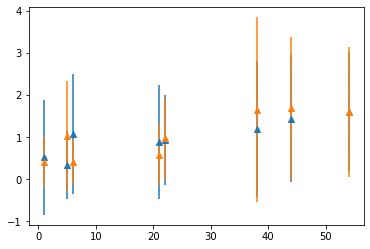

In [ ]:
t = [int(i[:2]) for i in sorted(listdir(folder))]
plt.errorbar(t, means[:,0]/np.median(means[:,0]), stds[:,0]/np.median(means[:,0]), linestyle='None', marker='^')
plt.errorbar(t, means[:,1]/np.median(means[:,1]), stds[:,1]/np.median(means[:,1]), linestyle='None', marker='^')
print(np.std(means[:,1]),max(stds[:,1]))
plt.show()